<a href="https://colab.research.google.com/github/jurados/AstroinformaticProject/blob/main/kbmod_stamps_access_w_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# KBMOD Coadd Stamps

## README

The following data was generated for use as part of the [KBMOD](https://github.com/dirac-institute/kbmod) project, for the purpose of creating a machine learning model to filter out false positve results from the KBMOD search. The data set is divided into two sets of data, the true positive and false positive, with each set also divided into the training, validation, and test sets for ML purposes.

### True Positive

This dataset was generated based on the synthetic objects inserted into the DEEP data by Pedro Bernardinelli, and then cutout from the survey dataset by Steven Stetzler. The original stamp cutouts are available on hyak at `/gscratch/dirac/DEEP/collab/fakes_cutouts/data/*/npy` (the `*` being the id of the fake object in DEEP).

### False Positive

This dataset was generated by running KBMOD on the DEEP data, but setting the set of serach angles to be roughly perpendicular to the ecliptic. This allows us to semi-safely assume that any search results are not real or inserted objects (i.e., while some real or synthetic objects may have been included in this set, the ratio to bad results is small enough to not be of concern for machine learning purposes).

### Data Transformation

Each source observation in the above set was ran through a series of random transformations, to enlarge the dataset and to capture all possible features of both sets. Those transformations were:
- select a random subset of the total set to coadd, with a minimum number of observations set to 25
    - so if the N number of observations is > 25 then the set of stamps used in coadding is of length [25,N]
- potentially offset the center pixel of each stamp by one in either direction, for both the X and Y in pixel space
    - so the set x_offset = [-1, 0, 1] and y_offset = [-1, 0, 1], creating nine potential offset states around the "actual" center of the object/results.
- potentially mirror around both the x and y axis
- potentially rotate 90 degrees around the center N times, where N is [0-3]

### Data Format

The data arrays are stored as numpy `.npy` files, and can be loaded with `x = np.load(PATH)`.

The shape of the data is `(N, 3, 21, 21)`, where N is the number of individual stamps in each set. The second dimmension corresponds to the type of coadd performed.
- index 0 = median coadd stamp
- index 1 = mean coadd stamp
- index 2 = sum coadd stamp.
Side note: the true positive stamp files also have an index 3, which corresponds to the recently added variance weighted coadd stamps. However, we found some discrepancies in those stamps and decided not to generate them for the false positive stamp. You can filter out this fourth column from the true positive set by slicing the array like [:,:3,:,:].

Each coadd stamp has the shape (21,21).

## Data

Here are the preloaded data sets. If you want to generate your own train, test, and validation sets, you can load in the `true_positive_stamps_full.npy` and `false_positive_stamps_full.npy` files.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/(POSGRADO) Universidad de Chile/ELECTIVE - Astroinformatic/Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/(POSGRADO) Universidad de Chile/ELECTIVE - Astroinformatic/Project


In [4]:
data_dir = "./kbmod_ml_stamps/"

# TRUE POSITVE PATHS
true_pos_full = os.path.join(data_dir, "true_positive_stamps_full.npy")
true_pos_train = os.path.join(data_dir, "true_train_stamps.npy")
true_pos_valid = os.path.join(data_dir, "true_valid_stamps.npy")
true_pos_test = os.path.join(data_dir, "true_test_stamps.npy")

# FALSE POSITVE PATHS
false_pos_full = os.path.join(data_dir, "false_positive_stamps_full.npy")
false_pos_train = os.path.join(data_dir, "false_train_stamps.npy")
false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
false_pos_test = os.path.join(data_dir, "false_test_stamps.npy")

In [5]:
true_train = np.load(true_pos_train)[:,:3,:,:] # this indexing isn't strictly needed if you're just grabbing one of the other coadd type columns, see below cell.
true_test = np.load(true_pos_test)[:,:3,:,:]

false_train = np.load(false_pos_train)

true_train.shape, false_train.shape

((129010, 3, 21, 21), (110530, 3, 21, 21))

In [6]:
true_train_median = true_train[:,0,:,:]
false_train_median = false_train[:,0,:,:]

true_train_median.shape, false_train_median.shape

((129010, 21, 21), (110530, 21, 21))

## Visualization

If you want to visualize what certain stamps look like, you can use `plt.imshow` and pass in the desired row.

Side note on visualizing the true positive stamps: we specifically weakened the signal on some of the observations to simulate a wider range of data. Visualizing some of the stamps might seem like mostly random noise, but I do promise there is signal there. Some of the time the PSF isn't visible in the median stamp but is seen in the mean or sum, or vice versa. I'm still messing around with the dataset so if we're running into too much low-SNR contimination in this set, we can raise the minimum observations in the selection algorithm and rerun everything, it only takes about 20 minutes to do :)

In [7]:
def plot_true_false(true, false):
    '''Plot a random set of true and false images'''
    fig_0,ax_0 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    fig_1,ax_1 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    ax_0 = ax_0.reshape(-1)
    ax_1 = ax_1.reshape(-1)
    true_int_list = np.random.choice(len(true),10,replace=False)
    false_int_list = np.random.choice(len(false),10,replace=False)
    for i, ax in enumerate(ax_0):
        ax.imshow(true[true_int_list[i]])
    for i, ax in enumerate(ax_1):
        ax.imshow(false[false_int_list[i]])
    fig_0.suptitle('True',fontsize=16)
    fig_1.suptitle('False',fontsize=16)
    fig_0.tight_layout()
    fig_1.tight_layout()

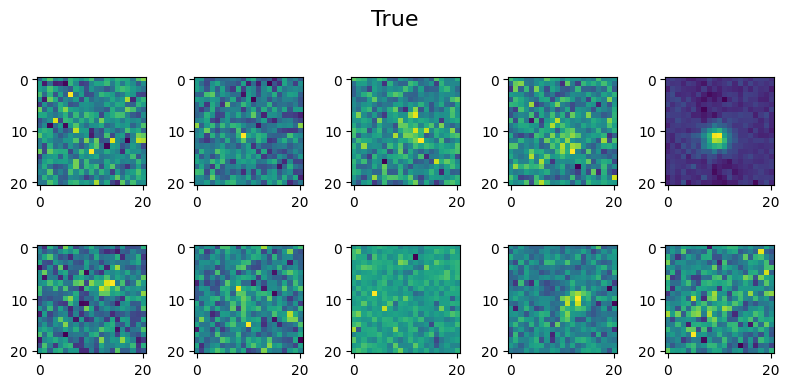

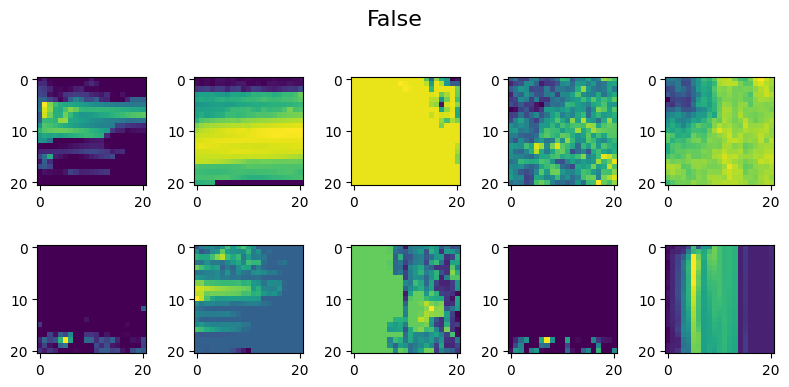

In [8]:
plot_true_false(true_train[:,0,:,:], false_train[:,0,:,:])

## Training

I've included a simple model here as jumping off point. Go wild!

In [9]:
false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
_a = np.load(false_pos_valid)

In [10]:
# combine data
def stack_data(f, t):
    input_stamps = np.vstack([f, t])
    stamp_class = np.zeros(len(f) + len(t), dtype=int)
    stamp_class[len(f):] = 1

    rand_state = np.random.RandomState(32)
    idx = rand_state.permutation(len(input_stamps))
    input_stamps = input_stamps[idx]
    stamp_class = stamp_class[idx]

    num_classes = int(np.max(stamp_class)) + 1
    stamp_class = np.eye(num_classes)[stamp_class]
    return input_stamps, stamp_class

In [11]:
true_valid_median = np.load(true_pos_valid)[:,0,:,:]
false_valid_median = np.load(false_pos_valid)[:,0,:,:]

train_data, train_class = stack_data(false_train_median, true_train_median)
val_data, val_class = stack_data(false_valid_median, true_valid_median)

train_data = train_data.reshape(-1,21,21,1)
val_data = val_data.reshape(-1,21,21,1)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/")

from torchsummary import summary

from tqdm.auto import tqdm

device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

Shape:
- Input:  $(N,C_{in},H_{in}, W_{in})$ or $(C_{in},H_{in}, W_{in})$
- Output: $(N,C_{out},H_{out}, W_{out})$ or $(C_{out},H_{out}, W_{out})$

Parameters:
- `in_channels`
- `out_channels`
- `kernel_size`
- `stride`: Default value is 1.
- `padding`: Default value is 0.
- `dilation`: Default value is 1.
- `groups`: controls the connections between inputs and outputs.
- `bias`: If `True`, adds a learnable bias to the output.
- `padding_mode`


$$ H_{out}=\left[\frac{H_{in}+2 \times \text{padding}[0]-\text{dilation}[0] \times (\text{kernel_size}[0]- 1)- 1}{\text{stride}[0]} +1 \right]
$$
$$ W_{out}=\left[\frac{W_{in}+2 \times \text{padding}[1]-\text{dilation}[1] \times (\text{kernel_size}[1]- 1)- 1}{\text{stride}[0]} +1 \right]
$$

Parameters:
- `kernel_size`
- `stride`: Default value is `kernel_size`.
- `padding`
- `dilation`
- `return_indices`: If `True`, will return te max indices along with the outputs. Useful for `torch.nn.MaxUnpool2d` later.
- `ceil_mode`: when `True`, will use _ceil_ instead of _floor_ to compute the output shape.


[`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

Shape:
- Input:  $(N,C,H_{in}, W_{in})$ or $(C,H_{in}, W_{in})$
- Output: $(N,C,H_{out}, W_{out})$ or $(C,H_{out}, W_{out})$

Parameters:
- `kernel_size`
- `stride`: Default value is `kernel_size`.
- `padding`
- `dilation`
- `return_indices`: If `True`, will return te max indices along with the outputs. Useful for `torch.nn.MaxUnpool2d` later.
- `ceil_mode`: when `True`, will use _ceil_ instead of _floor_ to compute the output shape.

$$ H_{out}=\left[\frac{H_{in}+2 \times \text{padding}[0]-\text{dilation}[0] \times (\text{kernel_size}[0]- 1)- 1}{\text{stride}[0]} +1 \right]
$$
$$ W_{out}=\left[\frac{W_{in}+2 \times \text{padding}[1]-\text{dilation}[1] \times (\text{kernel_size}[1]- 1)- 1}{\text{stride}[0]} +1 \right]
$$

### Model V0

In [13]:
class ModelV0(nn.Module):
    def __init__(self,
                 input_shape=(21, 21, 1),
                 n_classes=2):
        super().__init__()
        self.model_layers = nn.Sequential(
            # Input (Cin=1, Hin=21, Win=21, kenel_size=3, stride=1, padding=0, dilation=1)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            # Output (Cout=8, Hin=18, Win=18)
            nn.ReLU(),
            # Output (Cout=8, Hin=18, Win=18)
            nn.BatchNorm2d(num_features=8),
            # Output (Cout=8, Hin=18, Win=18)
            nn.MaxPool2d(kernel_size=2),
            # Output (Cout=8, Hin=9, Win=9)
            nn.Dropout(p=0.25),
            # Output (Cout=8, Hin=9, Win=9)
            nn.Flatten(),
            # Output (8*9*9)
            nn.Linear(in_features=8*9*9, out_features=64),
        )
        self.activation = nn.Sigmoid() if n_classes == 1 else nn.Softmax(dim=1)
        self.fc_out = nn.Linear(in_features=64, out_features=n_classes)

    def forward(self, x):
        # print(x.shape) # [Batch, Heigh, Width, Channel]
        x = x.view(x.size(0), 1, 21, 21)
        #x = x.permute(0,3,1,2) # # [Batch, Channel, Heigh, Width]
        x = self.model_layers(x)
        x = self.fc_out(x)
        x = self.activation(x)
        return x

model = ModelV0().to(device) # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]              80
              ReLU-2            [-1, 8, 19, 19]               0
       BatchNorm2d-3            [-1, 8, 19, 19]              16
         MaxPool2d-4              [-1, 8, 9, 9]               0
           Dropout-5              [-1, 8, 9, 9]               0
           Flatten-6                  [-1, 648]               0
            Linear-7                   [-1, 64]          41,536
            Linear-8                    [-1, 2]             130
           Softmax-9                    [-1, 2]               0
Total params: 41,762
Trainable params: 41,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.16
Estimated Total Size (MB): 0.24
---------------------------------------------

### Model V1: ResNet-56

In [14]:
conv_k3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride=stride,
kernel_size=3, padding=1)

class ResidualBlock(nn.Module):
    """

    change_size: flag to indicate if activations are within normal residual blocks
    """

    def __init__(self, in_channel, out_channel, stride=1, change_size=True):
        super().__init__()
        self.conv1 = conv_k3(in_channel, out_channel, stride)
        self.bn1   = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k3(out_channel, out_channel, 1)
        self.bn2   = nn.BatchNorm2d(out_channel)
        self.change_size = change_size
        # for changing activation map sizes
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, out_channel,
                                            kernel_size=1, stride=stride),
                                nn.BatchNorm2d(out_channel)
            )

    def forward(self,x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity

        return F.relu(y)


class ModelV1(nn.Module):
    """RestNet56
    """
    def __init__(self, n=9, num_classes=2):
        super().__init__()
        self.conv1  = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, out_channel=16, stride=1, change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, out_channel=32, stride=2, change_size=True)
        self.block3 = self.create_block(n=9, in_channel=32, out_channel=64, stride=2, change_size=True)
        self.fc     = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [ResidualBlock(in_channel, out_channel, stride, change_size)]
        for i in range(n-1):
            block.append(ResidualBlock(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)

    def forward(self, x):
        x = x.view(x.size(0), 1, 21, 21)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block1(y)
        y = self.block2(y)
        y = self.block3(y)
        y = F.adaptive_avg_pool2d(input=y, output_size=1)
        return self.fc(y.view(y.size(0), -1))

model = ModelV1().to(device)   # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 21, 21]             160
       BatchNorm2d-2           [-1, 16, 21, 21]              32
            Conv2d-3           [-1, 16, 21, 21]           2,320
       BatchNorm2d-4           [-1, 16, 21, 21]              32
            Conv2d-5           [-1, 16, 21, 21]           2,320
       BatchNorm2d-6           [-1, 16, 21, 21]              32
     ResidualBlock-7           [-1, 16, 21, 21]               0
            Conv2d-8           [-1, 16, 21, 21]           2,320
       BatchNorm2d-9           [-1, 16, 21, 21]              32
           Conv2d-10           [-1, 16, 21, 21]           2,320
      BatchNorm2d-11           [-1, 16, 21, 21]              32
    ResidualBlock-12           [-1, 16, 21, 21]               0
           Conv2d-13           [-1, 16, 21, 21]           2,320
      BatchNorm2d-14           [-1, 16,

### Model V2: ResNet-50

Here, model_parameters[‘resnet50’] = ([64,128,256,512],[3,4,6,3],4,True) represents the parameters for resnet-50 where

[64,128,256,512] -> channels in each intermediate block
[3,4,6,3] -> # repeatition for Bottlenecks in each block
4 -> expansion_factor. Note that 64 turns to 256, 128 to 512. All the resnet layers use the same expansion factor.
True -> create Bottleneck layer status. True only for ResNet 50+


In [26]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion, is_Bottleneck):
        super(Bottleneck, self).__init__()
        self.expansion = expansion
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_Bottleneck = is_Bottleneck

        if self.in_channels == self.out_channels*self.expansion:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(self.in_channels, self.out_channels*self.expansion, kernel_size=1, stride=stride))
            # Only Conv -> BN and no Relu
            # projection_layer.append(nn.ReLu())
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

        # is_Bottleneck = True for all ResNet
        if self.is_Bottleneck:
            # Bottleneck
            # 1x1
            self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1)
            self.bn1 = nn.BatchNorm2d(self.out_channels)
            # 3x3
            self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn2 = nn.BatchNorm2d(self.out_channels)
            # 1x1
            self.conv3 = nn.Conv2d(self.out_channels, self.out_channels  * self.expansion, kernel_size=1, stride=1)
            self.bn3 = nn.BatchNorm2d(self.out_channels*self.expansion)

    def forward(self, x):
        identity = x
        if self.is_Bottleneck:
            # conv1x1 -> BN -> ReLU
            x = self.relu(self.bn1(self.conv1(x)))
            # conv3x3 -> BN -> ReLU
            x = self.relu(self.bn2(self.conv2(x)))
            # conv1x1 -> BN
            x = self.bn3(self.conv3(x))

        if self.identity:
            x += identity
        else:
            x += self.projection(identity)
        x = self.relu(x)
        return x

class ModelV2(nn.Module):
    """
    ResNet-50 model
    """

    def __init__(self, in_channels, num_classes):
        super(ModelV2, self).__init__()

        self.channels_list = [64,128,256,512]
        self.repeatition_list = [3,4,6,3]
        self.expansion = 4
        self.is_Bottleneck = True

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.block1 = self._make_blocks(64, self.channels_list[0], 3, stride=1, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block2 = self._make_blocks(self.channels_list[0]*self.expansion, self.channels_list[1], self.repeatition_list[1], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block3 = self._make_blocks(self.channels_list[1]*self.expansion, self.channels_list[2], self.repeatition_list[2], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block4 = self._make_blocks(self.channels_list[2]*self.expansion, self.channels_list[3], self.repeatition_list[3], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3]*self.expansion, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), 1, 21, 21)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        return x

    def _make_blocks(self, in_channels, out_channels, num_repeat, stride, expansion, is_Bottleneck):
        layers = [Bottleneck(in_channels, out_channels, stride, expansion, is_Bottleneck)]
        for i in range(1, num_repeat):
            layers.append(Bottleneck(out_channels*expansion, out_channels, 1, expansion, is_Bottleneck))
        return nn.Sequential(*layers)

model = ModelV3(in_channels=1, num_classes=2).to(device)   # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 11, 11]           3,200
       BatchNorm2d-2           [-1, 64, 11, 11]             128
              ReLU-3           [-1, 64, 11, 11]               0
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 6, 6]           4,160
       BatchNorm2d-6             [-1, 64, 6, 6]             128
              ReLU-7             [-1, 64, 6, 6]               0
            Conv2d-8             [-1, 64, 6, 6]          36,928
       BatchNorm2d-9             [-1, 64, 6, 6]             128
             ReLU-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 256, 6, 6]          16,640
      BatchNorm2d-12            [-1, 256, 6, 6]             512
           Conv2d-13            [-1, 256, 6, 6]          16,640
             ReLU-14            [-1, 25

In [27]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()


In [28]:
# This model is upload
from torchvision.models import resnet50

### Training and Validation

In [29]:
def train(network, train_data, train_labels, batch_size, optimizer, loss_function, device):
    """
    Trains the network using the provided training data and labels for one epoch.

    Params
    --------
    network : torch.nn.Module
        The neural network model to train.
    train_data : torch.Tensor
        Tensor containing the input features for training.
    train_labels : torch.Tensor
        Tensor containing the target labels for training.
    batch_size : int
        Number of samples per batch.
    optimizer : torch.optim.Optimizer
        Optimizer for model training.
    loss_function : callable
        Loss function for model training.
    device : torch.device
        Device to perform computations (CPU or GPU).

    Returns
    --------
    loss_per_batch : list
        List of loss values for each batch.
    train_acc : float
        Accuracy of the model on the training data.
    """

    train_data = torch.tensor(train_data)
    train_labels = torch.tensor(train_labels)

    # Creating dataset and DataLoader
    training_set = TensorDataset(train_data, train_labels)
    train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

    # creating list to hold loss per batch
    loss_per_batch = []
    acc_per_batch  = []

    # defining dataloader
    train_loss, train_acc = 0, 0

    print('Training ....')
    network.train()
    for stamps, labels in tqdm(train_dataloader):

        # Move to device
        stamps, labels = stamps.to(device), labels.to(device)

        # Forward pass
        labels_predict = network(stamps)

        # Calculate loss
        loss = loss_function(labels_predict, labels)
        loss_per_batch.append(loss.item())
        train_loss += loss.item()

        # Accuracy calculation (compare predicted with true labels)
        _, predicted = torch.max(labels_predict, 1)  # Get the predicted class (index of max probability)
        correct_predictions = (predicted == labels.argmax(dim=1)).sum().item()
        train_acc += correct_predictions  # Correct predictions for the batch
        acc_per_batch.append(correct_predictions)

        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss BackwardLoss
        loss.backward()
        # Optimizer step
        optimizer.step()

    train_acc /= len(train_data)  # average accuracy over batches

    return loss_per_batch,  acc_per_batch, train_acc

def validate(network, validation_data, validation_labels, batch_size, optimizer, loss_function, device):
    """
    Validing the network using the provided validation data and labels for one epoch.

    Params
    --------
    network : torch.nn.Module
        The neural network model to validate.
    validate_data : torch.Tensor
        Tensor containing the input features for validating.
    validate_labels : torch.Tensor
        Tensor containing the target labels for validating.
    batch_size : int
        Number of samples per batch.
    optimizer : torch.optim.Optimizer
        Optimizer for model validating.
    loss_function : callable
        Loss function for model validating.
    device : torch.device
        Device to perform computations (CPU or GPU).

    Returns
    --------
    loss_per_batch : list
        List of loss values for each batch.
    validate_acc : float
        Accuracy of the model on the training data.
    """
    validation_data = torch.tensor(validation_data)
    validation_labels = torch.tensor(validation_labels)

    # Creating dataset and DataLoader
    validating_set = TensorDataset(validation_data, validation_labels)
    validation_dataloader = DataLoader(validating_set, batch_size=batch_size, shuffle=True)

    # creating list to hold loss per batch
    loss_per_batch = []
    acc_per_batch  = []

    # defining dataloader
    val_loss, val_acc = 0, 0

    print('Validating ....')
    with torch.inference_mode():
        for stamps, labels in tqdm(validation_dataloader):

            stamps, labels = stamps.to(device), labels.to(device)

            # Forward pass
            labels_predict = network(stamps)

            # Calculate loss
            loss = loss_function(labels_predict, labels)
            loss_per_batch.append(loss.item())

            # Accuracy calculation (compare predicted with true labels)
            _, predicted = torch.max(labels_predict, 1)  # Get the predicted class (index of max probability)
            correct_predictions = (predicted == labels.argmax(dim=1)).sum().item()
            val_acc += correct_predictions  # Correct predictions for the batch
            acc_per_batch.append(correct_predictions)

    val_acc /= len(validation_data)  # average accuracy over batches
    return loss_per_batch, acc_per_batch, val_acc

In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [31]:
train_dataset = CustomDataset(train_data[:100], train_class[:100])
validation_dataset = CustomDataset(val_data[:100], val_class[:100])

In [ ]:
initial_settings = {
    'batch_size': 512,
    'learning_rate': 0.005,
    'epochs': 10,
}

results = {
    'epochs': [],
    'training_loss_per_batch': [],
    'validation_loss_per_batch': [],
    'training_loss_per_epoch': [],
    'validation_loss_per_epoch': [],
    'training_acc_per_epoch': [],
    'validation_acc_per_epoch': []
}

#model = ModelV0().to(device)
#model = ModelV1().to(device)
model = ModelV2(in_channels=1, num_classes=2).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_settings['learning_rate'])

# Defining loss function
loss_function = nn.CrossEntropyLoss()

for epoch in range(initial_settings['epochs']):
    print(f"Epoch: {epoch}\n ----")
    results['epochs'].append(epoch)
    ### trainning
    train_loss, _, train_acc = train(model, train_data, train_class, initial_settings['batch_size'], optimizer, loss_function, device)
    results['training_loss_per_batch'].append(train_loss)
    results['training_loss_per_epoch'].append(np.sum(train_loss)/len(train_loss))
    results['training_acc_per_epoch'].append(train_acc)
    print('Total loss per epoch:', np.sum(train_loss)/len(train_loss))
    print('Total acc per epoch:', train_acc)
    print('... Training Done')
    ### validation
    val_loss, _, val_acc = validate(model, val_data, val_class, initial_settings['batch_size'], optimizer, loss_function, device)
    results['validation_loss_per_batch'].append(val_loss)
    results['validation_loss_per_epoch'].append(np.sum(val_loss)/len(val_loss))
    results['validation_acc_per_epoch'].append(val_acc)
    print('Total loss per epoch:', np.sum(val_loss)/len(val_loss))
    print('Total acc per epoch:', val_acc)
    print('... Validation Done', end='\n\n')

Epoch: 0
 ----
Training ....


  0%|          | 0/468 [00:00<?, ?it/s]

Total loss per epoch: 0.31162312189261854
Total acc per epoch: 0.9075352759455624
... Training Done
Validating ....


  0%|          | 0/134 [00:00<?, ?it/s]

Total loss per epoch: 0.3372444639227782
Total acc per epoch: 0.8956750438340152
... Validation Done

Epoch: 1
 ----
Training ....


  0%|          | 0/468 [00:00<?, ?it/s]

Text(0, 0.5, 'Accuracy')

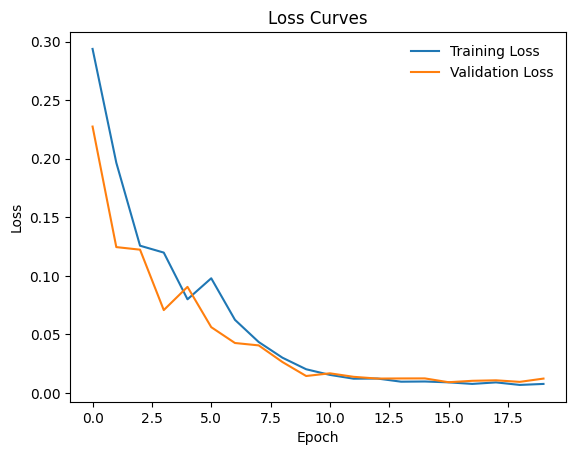

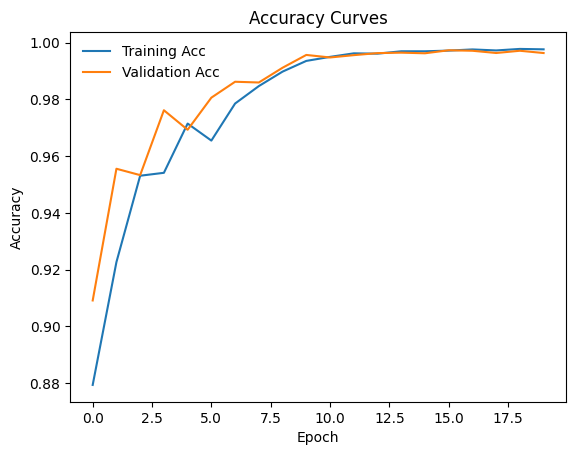

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(results['epochs'], results['training_loss_per_epoch'], label='Training Loss')
ax.plot(results['epochs'], results['validation_loss_per_epoch'], label='Validation Loss')
ax.set_title('Loss Curves')
ax.legend(frameon=False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig, ax = plt.subplots()
ax.plot(results['epochs'], results['training_acc_per_epoch'], label='Training Acc')
ax.plot(results['epochs'], results['validation_acc_per_epoch'], label='Validation Acc')
ax.set_title('Accuracy Curves')
ax.legend(frameon=False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

IndexError: index 15 is out of bounds for axis 0 with size 15

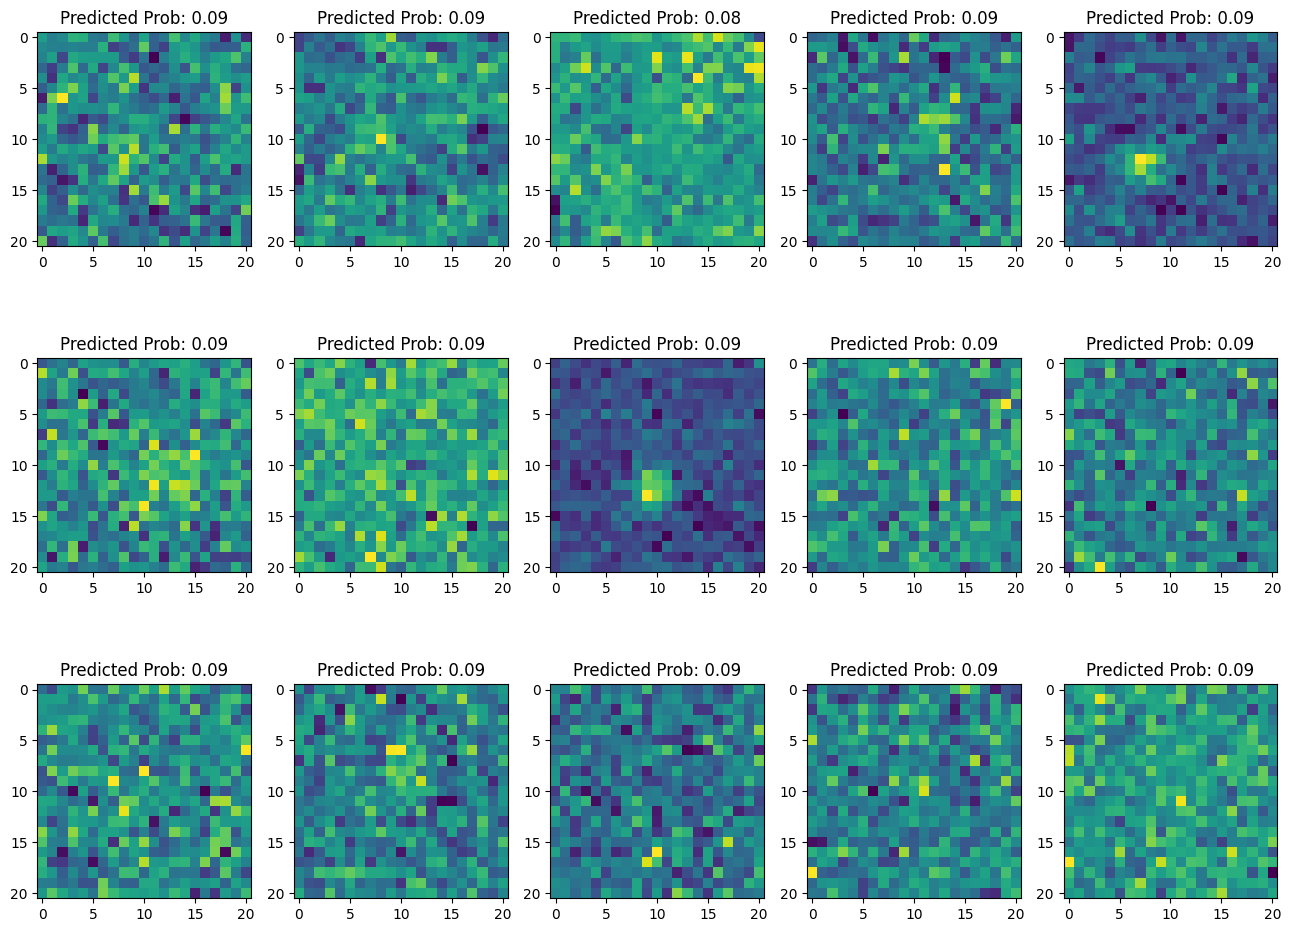

In [27]:
# Assuming `true_test` is the input tensor and `device` is set correctly
real_positives = torch.tensor(true_test[:, 0, :, :]).to(device)

# Predict probabilities with the model, ensuring no gradients are calculated
with torch.inference_mode():
    real_data_probs = ModelV1().to(device)(real_positives)  # Forward pass
# Convert real_data_probs to NumPy for plotting (move to CPU if necessary)
real_data_probs = real_data_probs.cpu().detach().numpy()

# Plot setup
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=[16, 12])
ax = ax.reshape(-1)
# Turn off all axes initially
[tmp_ax.set_axis_off() for tmp_ax in ax]
# Display each real positive with its predicted probability
for i, coadd in enumerate(real_positives):
    ax[i].set_axis_on()
    ax[i].imshow(coadd.cpu().numpy().reshape(21, 21))  # Convert to NumPy for imshow
    ax[i].set_title('Predicted Prob: {:.2f}'.format(real_data_probs[i, 1]))  # Probability of class 1
plt.show()

# Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

In [ ]:
def simple_model(input_shape=(21,21,1), n_classes: int = 2):
    model = tf.keras.models.Sequential(name='simple')
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_1'))
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))
    return(model)

In [ ]:
simple_cnn.summary()

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 19, 19, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 19, 19, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 648)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 64)                  │          41,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,542 (326.34 KB)

 Trainable params: 41,762 (163.13 KB)

 Non-trainable params: 16 (64.00 B)

 Optimizer params: 41,764 (163.14 KB)

In [ ]:
simple_cnn = simple_model(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.05, nesterov=True)
simple_cnn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs = 20
simple_model_history = simple_cnn.fit(train_data, train_class, epochs=n_epochs, batch_size=512, verbose=1, validation_data=(val_data, val_class), shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 53s 109ms/step - accuracy: 0.7534 - loss: 0.6086 - val_accuracy: 0.6412 - val_loss: 0.6572
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.8812 - loss: 0.3477 - val_accuracy: 0.6793 - val_loss: 0.6186
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 98s 143ms/step - accuracy: 0.8930 - loss: 0.2960 - val_accuracy: 0.6238 - val_loss: 0.6243
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 74s 127ms/step - accuracy: 0.9080 - loss: 0.2571 - val_accuracy: 0.5886 - val_loss: 0.6374
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 74s 109ms/step - accuracy: 0.9136 - loss: 0.2408 - val_accuracy: 0.6407 - val_loss: 0.6092
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.9053 - loss: 0.2434 - val_accuracy: 0.6254 - val_loss: 0.5943
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 78s 105ms/step - accuracy: 0.9233 - loss: 0.2139 - val_accuracy: 0.5783 - val_loss: 0.6721
Epoch 8/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.9193 - loss: 0

Text(0, 0.5, 'Accuracy')

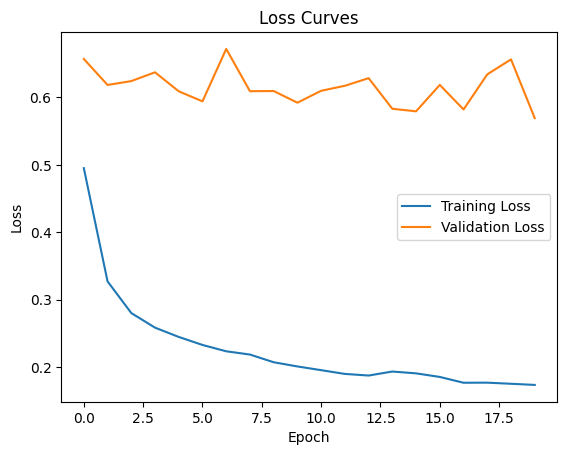

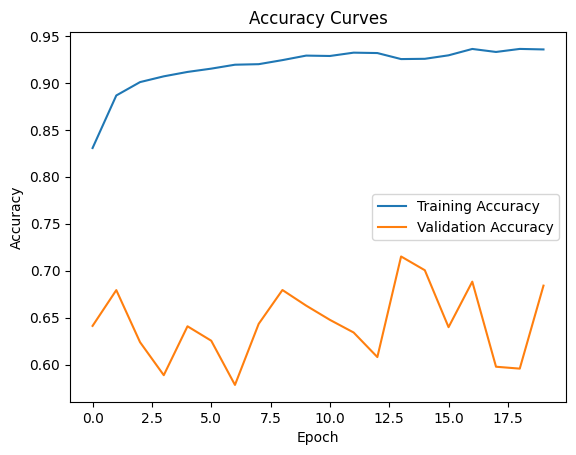

In [ ]:
model_history = simple_model_history
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.figure()
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Keras_Loss.png')
plt.figure()
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.savefig('figures/ResNet50_LC.png')